# 📊 Zeitstrahl für Training, Validierung und Test

**Gesamtbeschränkung:**  
- Maximal **10.000 Einträge** in Training  

---

## 📅 Originale Datenaufteilung:
- **Trainingsdaten:** 2016-01-01 – 2022-12-13  
- **Validierungsdaten:** 2023-01-01 – 2023-12-31  
- **Testdaten:** 2024-01-01 – 2024-12-31  

---

## 🔄 Neue Strategie für einen besseren Vergleich mit NGBoost:
Da mein anderes Modell **NGBoost** direkt auf allen Validierungsdaten (2023) ausgewertet werden kann, verwende ich für dieses Modell eine alternative Strategie.  
Anstatt alle Daten von 2016–2022 zu nutzen, wird nur das letzte verfügbare Jahr (**2022**) als Trainingsbasis herangezogen.  
Für jede Quartalsperiode in 2023 wird das entsprechende Quartal in 2022 als Trainingsdatensatz genutzt.

### 📌 Quartalsweise Trainings- & Validierungsaufteilung:

| Split  | Train-Zeitraum        | Validierungszeitraum | CRPS  | NLL  |
|--------|----------------------|----------------------|-------|------|
| **1️⃣ Q1**  | 2022-01-01 – 2022-03-31  | 2023-01-01 – 2023-03-31  | CRPS₁ | NLL₁ |
| **2️⃣ Q2**  | 2022-04-01 – 2022-06-30  | 2023-04-01 – 2023-06-30  | CRPS₂ | NLL₂ |
| **3️⃣ Q3**  | 2022-07-01 – 2022-09-30  | 2023-07-01 – 2023-09-30  | CRPS₃ | NLL₃ |
| **4️⃣ Q4**  | 2022-10-01 – 2022-12-31  | 2023-10-01 – 2023-12-31  | CRPS₄ | NLL₄ |

### 📊 Durchschnittliche Bewertung:
Nach Durchführung der vier Experimente werden die finalen Metriken berechnet als:

Durchschnittlicher CRPS:
(CRPS₁ + CRPS₂ + CRPS₃ + CRPS₄) / 4

Durchschnittliche NLL:
(NLL₁ + NLL₂ + NLL₃ + NLL₄) / 4


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from analysis.datasets import load_entsoe
from analysis.splits import to_train_validation_test_data
from analysis.transformations import scale_power_data
from tabpfn import TabPFNRegressor
from analysis.transformations import add_interval_index, add_lagged_features
from torchinfo import summary
from analysis.TabPFN_copy import evaluate
import torch
import seaborn as sns
from analysis.TabPFN_copy import fit_tail_distribution, plot_cdf_pdf_dynamic, plot_pdf_from_logits
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def compute_crps_pytorch(logits, bin_edges, y_values):
    """
    Computes the CRPS for multiple rows of logits and corresponding y-values using PyTorch.

    Args:
        logits: Tensor of shape (N, 5000) - unnormalized logits for each row.
        bin_edges: Tensor of shape (5001,) - common bin edges for all rows.
        y_values: Tensor of shape (N,) - target values for each row.

    Returns:
        Tensor of shape (N,) containing the CRPS values for each row.
    """

    # Convert logits to probabilities using softmax
    probs = torch.softmax(logits, dim=1)  # (N, 5000)

    # Compute CDF (cumulative sum of probabilities)
    cdf = torch.cumsum(probs, dim=1)  # (N, 5000)

    # Compute the indicator function (1 if bin edge >= y, else 0)
    # We need to compare each y_value with bin_edges and broadcast correctly
    indicators = (bin_edges[1:].unsqueeze(0) >= y_values.unsqueeze(1)).float()  # (N, 5000)

    # Step 4: Compute bin widths
    bin_widths = (bin_edges[1:] - bin_edges[:-1]).unsqueeze(0)  # (1, 5000)

    # Step 5: Compute CRPS integral for each row
    crps = torch.sum((cdf - indicators) ** 2 * bin_widths, dim=1)  # (N,)

    return crps


In [14]:
feature_columns = ['ws_10m_loc_mean', 'ws_100m_loc_mean', 'power_t-96']
target_column='power'

entsoe = load_entsoe()
entsoe = scale_power_data(entsoe)
entsoe = add_lagged_features(entsoe)
entsoe = add_interval_index(entsoe)
entsoe.dropna(inplace=True)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)


In [15]:
train_end = "2022-12-31 23:45:00"
validation_end = "2023-12-31 23:45:00"

train, validation, test = to_train_validation_test_data(entsoe, train_end, validation_end)
X_train, y_train = train[feature_columns], train[target_column]
X_validation, y_validation = validation[feature_columns], validation[target_column]

# of training observations: 245376 | 77.76%
# of validation observations: 35040 | 11.10%
# of test observations: 35133 | 11.13%


# Train 4 models for each quarter

In [16]:
# Define the train-validation splits
splits = {
    #"first_q": {
    #    "train": ("2022-01-01", "2022-03-31"),
    #    "validation": ("2023-01-01", "2023-03-31"),
        #"train": ("2022-01-01", "2022-01-03"),
        #"validation": ("2023-01-01", "2023-01-03"),
    #}#,
    #"second_q": {
    #    "train": ("2022-04-01", "2022-06-30"),
    #    "validation": ("2023-04-01", "2023-06-30"),
        #"train": ("2022-01-04", "2022-01-06"),
        #"validation": ("2023-01-04", "2023-01-06"),
    #},
    #"third_q": {
    #    "train": ("2022-07-01", "2022-09-30"),
    #    "validation": ("2023-07-01", "2023-09-30"),
    #},
    "fourth_q": {
         #"train": ("2022-10-01", "2022-12-31"),
        "train": ("2022-10-01", "2022-10-07"),
         #"validation": ("2023-10-01", "2023-12-31"),
        "validation": ("2023-12-26", "2023-12-31")
    }
}
# Initialize dictionary to store results
results_dict = {}
summary_stats_overall = {}

# Loop through each quarter
for quarter, dates in splits.items():
    print(f"Processing {quarter}...")

    # Extract train and validation data
    X_train_q = X_train.loc[dates["train"][0]:dates["train"][1]]
    y_train_q = y_train.loc[dates["train"][0]:dates["train"][1]]
    
    X_validation_q = X_validation.loc[dates["validation"][0]:dates["validation"][1]]
    y_validation_q = y_validation.loc[dates["validation"][0]:dates["validation"][1]]

    # Train model
    model = TabPFNRegressor(device='auto', fit_mode='low_memory', random_state=42)
    model.fit(X_train_q, y_train_q)

    # Define quantiles
    quantiles_custom = np.arange(0.1, 1, 0.1)
    probabilities_q = quantiles_custom

    # Predict
    probs_val_q = model.predict(X_validation_q, output_type="full", quantiles=quantiles_custom)
    logits_q = probs_val_q["logits"]
    borders_q = probs_val_q["criterion"].borders
    all_quantiles_q = np.array(probs_val_q["quantiles"])

    # Convert y_validation to tensor
    y_validation_q_torch = torch.tensor(y_validation_q.values, dtype=torch.float32)

    # Compute CRPS and NLL using the 5000 logits and 5001 borders from TabPFN
    crps_values_torch_q = compute_crps_pytorch(logits_q, borders_q, y_validation_q_torch)
    print(f"CRPS shape for {quarter}:", crps_values_torch_q.shape)


    # Initialize max_nll_so_far to a very small number
    max_nll_so_far = float('-9999')
    nll_torch_q = probs_val_q["criterion"].forward(logits_q, y_validation_q_torch)

    # Find the max ignoring inf and NaN
    finite_nlls = nll_torch_q[torch.isfinite(nll_torch_q)]

    if finite_nlls.numel() > 0:  # numel() = number of elements in finite_nlls
        max_nll_so_far = max(max_nll_so_far, finite_nlls.max().item())
        print(f"Updated max_nll_so_far to: {max_nll_so_far} based on the current finite NLLs")

    # Find the indices of the infinite values
    infinite_indices = torch.nonzero(~torch.isfinite(nll_torch_q)).squeeze()

    # Replace infinite values with max_nll_so_far
    infinite_values = nll_torch_q[infinite_indices]
    nll_torch_q[~torch.isfinite(nll_torch_q)] = max_nll_so_far

    # Print out the indices and the values that were replaced
    print(f"Replaced infinite values at indices {infinite_indices.tolist()} in nll_torch_q with the value {max_nll_so_far}.")


    # Fit tails
    yt = entsoe["power"]
    quantile_10 = np.percentile(yt, probabilities_q * 100)
    mu_left_asym, sigma_left_asym = fit_tail_distribution(quantile_10[:2], probabilities_q[:2])
    mu_right_asym, sigma_right_asym = fit_tail_distribution(quantile_10[-2:], probabilities_q[-2:])

    # Initialize lists for CRPS and NLL calculations of the 9 deciles
    crps_cdf_linear_a_full_q = []
    crps_hybrid_cdf_a_full_q = []
    crps_normal_a_full_q = []
    nll_pdf_linear_a_full_q = []
    nll_pdf_hybrid_a_full_q = []
    nll_normal_a_full_q = []

    # Iterate through validation samples
    for i in range(y_validation_q.shape[0]):
        quantile_i = all_quantiles_q[:, i]
        y_i = y_validation_q.iloc[i]

        # Compute evaluation metrics
        cdf_linear, hybrid_cdf, crps_normal, pdf_linear, pdf_hybrid, nll_normal = evaluate(
            quantile_i, probabilities_q, y_i, -20, 5, mu_left_asym, sigma_left_asym, mu_right_asym, sigma_right_asym
        )

        # Store results
        crps_cdf_linear_a_full_q.append(cdf_linear)
        crps_hybrid_cdf_a_full_q.append(hybrid_cdf)
        crps_normal_a_full_q.append(crps_normal)
        nll_pdf_linear_a_full_q.append(pdf_linear)
        nll_pdf_hybrid_a_full_q.append(pdf_hybrid)
        nll_normal_a_full_q.append(nll_normal)

    # Compute mean values
    mean_crps_cdf_linear_q = np.mean(crps_cdf_linear_a_full_q)
    mean_crps_hybrid_cdf_q = np.mean(crps_hybrid_cdf_a_full_q)
    mean_crps_normal_q = np.mean(crps_normal_a_full_q)
    mean_nll_pdf_linear_q = np.mean(nll_pdf_linear_a_full_q)
    mean_nll_pdf_hybrid_q = np.mean(nll_pdf_hybrid_a_full_q)
    mean_nll_normal_q = np.mean(nll_normal_a_full_q)

    # Print mean values
    print(f"Mean CRPS for {quarter} - CDF Linear: {mean_crps_cdf_linear_q:.4f}")
    print(f"Mean CRPS for {quarter} - Hybrid CDF: {mean_crps_hybrid_cdf_q:.4f}")
    print(f"Mean CRPS for {quarter} - Normal: {mean_crps_normal_q:.4f}")
    print(f"Mean NLL for {quarter} - PDF Linear: {mean_nll_pdf_linear_q:.4f}")
    print(f"Mean NLL for {quarter} - PDF Hybrid: {mean_nll_pdf_hybrid_q:.4f}")
    print(f"Mean NLL for {quarter} - Normal: {mean_nll_normal_q:.4f}")

    # Convert logits to a Pandas DataFrame
    logits_df = pd.DataFrame(logits_q.cpu().numpy())

    # Rename columns for clarity
    logits_df.columns = [f"Logit_{i+1}" for i in range(logits_df.shape[1])]


    # Store results in dictionary
    result_q = {
        'CRPS Linear': crps_cdf_linear_a_full_q,
        'CRPS Hybrid': crps_hybrid_cdf_a_full_q,
        'CRPS Normal': crps_normal_a_full_q,
        'CRPS (5000 quantiles)': crps_values_torch_q,
        'NLL Linear': nll_pdf_linear_a_full_q,
        'NLL Hybrid': nll_pdf_hybrid_a_full_q,
        'NLL Normal': nll_normal_a_full_q,
        'NLL (5000 quantiles)': nll_torch_q,
        'y values': y_validation_q_torch,
    }

        
    # Convert to DataFrame and round values
    results_q = pd.DataFrame(result_q).round(8)

    # Merge logits with the results DataFrame
    results_q_with_logits = pd.concat([results_q, logits_df], axis=1)

    borders_df = pd.DataFrame(borders_q.cpu().numpy(), columns=["Borders"])

    results_dict[quarter] = {
        "results": results_q_with_logits,  # Store per-entry results
        "borders": borders_df,  # Store borders as a separate DataFrame
    }

    
    #results_dict[quarter] = results_q

    summary_stats_q = {
        'CRPS Linear': [mean_crps_cdf_linear_q, np.min(crps_cdf_linear_a_full_q), np.max(crps_cdf_linear_a_full_q), np.median(crps_cdf_linear_a_full_q)],
        'CRPS Hybrid': [mean_crps_hybrid_cdf_q, np.min(crps_hybrid_cdf_a_full_q), np.max(crps_hybrid_cdf_a_full_q), np.median(crps_hybrid_cdf_a_full_q)],
        'CRPS Normal': [mean_crps_normal_q, np.min(crps_normal_a_full_q), np.max(crps_normal_a_full_q), np.median(crps_normal_a_full_q)],
        'CRPS (5000 quantiles)': [crps_values_torch_q.mean().item(), np.min(crps_values_torch_q.cpu().numpy()), np.max(crps_values_torch_q.cpu().numpy()), np.median(crps_values_torch_q.cpu().numpy())],
        'NLL Linear': [mean_nll_pdf_linear_q, np.min(nll_pdf_linear_a_full_q), np.max(nll_pdf_linear_a_full_q), np.median(nll_pdf_linear_a_full_q)],
        'NLL Hybrid': [mean_nll_pdf_hybrid_q, np.min(nll_pdf_hybrid_a_full_q), np.max(nll_pdf_hybrid_a_full_q), np.median(nll_pdf_hybrid_a_full_q)],
        'NLL Normal': [mean_nll_normal_q, np.min(nll_normal_a_full_q), np.max(nll_normal_a_full_q), np.median(nll_normal_a_full_q)],
        'NLL (5000 quantiles)': [nll_torch_q.mean().item(), np.min(nll_torch_q.cpu().numpy()), np.max(nll_torch_q.cpu().numpy()), np.median(nll_torch_q.cpu().numpy())],
    }

    # Convert the summary stats into a DataFrame
    summary_stats_q_pd = pd.DataFrame(summary_stats_q, index=['Mean', 'Min', 'Max', 'Median'])
    summary_stats_overall[quarter] = summary_stats_q_pd

    # Print summary
    print("✅ Processing complete. Results stored in `results_dict`.")

Processing fourth_q...


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

CRPS shape for fourth_q: torch.Size([576])
Updated max_nll_so_far to: 9.801203727722168 based on the current finite NLLs
Replaced infinite values at indices [] in nll_torch_q with the value 9.801203727722168.


C:\Users\Minu\Documents\master-thesis\src\analysis\TabPFN_copy.py:359: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, y_min, y_max)
C:\Users\Minu\Documents\master-thesis\src\analysis\TabPFN_copy.py:359: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  crps_value, _ = quad(integrand, y_min, y_max)


Mean CRPS for fourth_q - CDF Linear: 0.3539
Mean CRPS for fourth_q - Hybrid CDF: 0.3356
Mean CRPS for fourth_q - Normal: 0.2941
Mean NLL for fourth_q - PDF Linear: 2.7026
Mean NLL for fourth_q - PDF Hybrid: 2.0062
Mean NLL for fourth_q - Normal: 5.7812
✅ Processing complete. Results stored in `results_dict`.


In [30]:
results_dict["fourth_q"]

{'results':      CRPS Linear  CRPS Hybrid  CRPS Normal  CRPS (5000 quantiles)  NLL Linear  \
 0       0.374810     0.310389     0.300146               0.300545    0.547953   
 1       0.474806     0.412501     0.400031               0.403512    4.053003   
 2       0.543784     0.487457     0.475470               0.478438    4.058555   
 3       0.617847     0.574728     0.566017               0.561413    4.072842   
 4       0.661528     0.623711     0.617849               0.611294    4.077596   
 ..           ...          ...          ...                    ...         ...   
 571     0.293792     0.306850     0.252004               0.248001    4.090767   
 572     0.310657     0.329232     0.273756               0.270615    4.092240   
 573     0.285812     0.297006     0.241285               0.238929    4.088447   
 574     0.285510     0.297802     0.240850               0.237815    4.086991   
 575     0.300203     0.318067     0.259487               0.257120    4.086740   
 
   

In [29]:
results_dict["fourth_q"]["results"].iloc[:, 9:]

,Logit_1,Logit_2,Logit_3,Logit_4,Logit_5,Logit_6,Logit_7,Logit_8,Logit_9,Logit_10,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,-9.027215,-8.885348,-10.278269,-10.547523,-10.686604,-11.044508,-11.505929,-11.475578,-11.472561,-11.684888,...,-13.177640,-13.034801,-12.949782,-12.834441,-13.158146,-13.052013,-11.619909,-11.761290,-11.379340,-9.493693
1,-8.446542,-8.744877,-9.985351,-10.189978,-10.409038,-10.679026,-11.133795,-11.119756,-11.113472,-11.322691,...,-13.197521,-13.048547,-12.968771,-12.854188,-13.162014,-13.073067,-11.637476,-11.798259,-11.401753,-9.514583
2,-8.766397,-8.963014,-10.232331,-10.451300,-10.657529,-10.934875,-11.394470,-11.372652,-11.370555,-11.572404,...,-13.416656,-13.272556,-13.181584,-13.069527,-13.372640,-13.268236,-11.846999,-12.020411,-11.600204,-9.697491
3,-9.043024,-9.218678,-10.460140,-10.683732,-10.883859,-11.159312,-11.616649,-11.592772,-11.594027,-11.789816,...,-13.658728,-13.510967,-13.421669,-13.303328,-13.602986,-13.505487,-12.092237,-12.274028,-11.852216,-9.987196
4,-8.916101,-9.195000,-10.385735,-10.582154,-10.806918,-11.051776,-11.501688,-11.482705,-11.482060,-11.676479,...,-13.711027,-13.538824,-13.447116,-13.335076,-13.627378,-13.533191,-12.135723,-12.318045,-11.887344,-10.045403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,-9.980105,-10.925239,-11.549645,-11.581799,-11.969406,-11.983608,-12.454338,-12.408621,-12.389315,-12.606261,...,-18.714973,-18.021828,-inf,-18.714973,-inf,-18.714973,-16.923214,-17.105536,-16.769064,-14.204114
572,-10.129016,-11.030805,-11.648436,-11.683865,-12.076209,-12.096428,-12.575515,-12.528272,-12.510740,-12.729554,...,-18.714973,-18.021828,-inf,-inf,-inf,-18.714973,-17.105536,-17.328680,-17.105536,-14.671923
573,-10.018249,-10.969647,-11.601058,-11.630556,-12.006809,-12.014100,-12.473330,-12.431065,-12.411355,-12.620166,...,-18.021828,-18.714973,-inf,-18.714973,-inf,-18.021828,-17.328680,-17.105536,-17.105536,-14.397486
574,-10.449990,-11.424850,-12.063545,-12.088308,-12.454851,-12.452756,-12.907784,-12.858788,-12.841151,-13.050168,...,-17.616362,-inf,-inf,-18.714973,-inf,-18.714973,-17.616362,-17.328680,-16.923214,-14.864826


still to be run for q4

In [24]:
import pickle


#filepath = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_first_q"
#filepath = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_second_q"
#filepath = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_third_q"
filepath = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_fourth_q"

with open(filepath, "wb") as file:
    pickle.dump(results_dict["fourth_q"], file)

In [25]:
with open(filepath, "rb") as file:
    fourth_quarter = pickle.load(file)

fourth_quarter

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),y values,Logit_1,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.251926,0.174959,0.187051,0.170426,0.484571,-0.815268,0.245122,0.262002,-2.298476,-19.013660,...,-inf,-inf,-inf,-14.953773,-inf,-inf,-inf,-inf,-17.616362,-14.204114
1,0.245930,0.170024,0.182793,0.171896,5.178007,-0.388919,0.220539,1.082626,-2.324590,-20.445480,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.452294
2,0.293540,0.219670,0.226174,0.231432,5.181585,0.116991,0.485396,3.098203,-2.323388,-19.991667,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.823153
3,0.454110,0.382441,0.404642,0.413469,5.188755,0.571732,2.480649,3.836962,-2.309077,-19.075420,...,-inf,-inf,-inf,-14.744682,-inf,-inf,-inf,-inf,-inf,-14.977304
4,0.648574,0.566627,0.640750,0.644148,5.206106,1.004765,3.727454,5.466805,-2.279903,-18.726599,...,-inf,-inf,-inf,-14.725990,-inf,-inf,-inf,-inf,-inf,-15.347678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,0.352947,0.314023,0.292830,0.294333,4.083904,1.522274,1.951467,3.267937,-0.756651,-18.452223,...,-inf,-inf,-inf,-15.313777,-inf,-inf,-inf,-inf,-inf,-14.604100
8828,0.373588,0.348251,0.326305,0.323240,4.088753,1.864039,4.303974,4.434358,-0.740979,-18.149229,...,-inf,-inf,-inf,-15.770535,-inf,-inf,-inf,-inf,-inf,-15.496099
8829,0.307834,0.270661,0.236159,0.238677,4.066889,0.680510,1.526312,2.142652,-0.755649,-19.353964,...,-inf,-inf,-inf,-15.382770,-inf,-inf,-inf,-inf,-inf,-14.823153
8830,0.302521,0.268084,0.231613,0.234095,4.066965,0.738175,1.464814,2.570757,-0.747790,-19.192339,...,-inf,-inf,-inf,-15.579479,-inf,-inf,-inf,-inf,-inf,-14.953773


In [26]:
np.save("tensor.npy", borders_q)

In [ ]:
borders_q.shape

torch.Size([5001])

In [6]:
print("model successfully trained")

model successfully trained


In [50]:
import pickle

with open("results.pkl", "wb") as f:
    pickle.dump(results_dict, f)

In [51]:
results_dict["first_q"]

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),y values,logits
0,0.286544,0.315913,0.196862,0.207918,-0.478470,-0.733121,0.405837,-0.590741,-0.539165,"[-18.4096622467041, -20.116853713989258, -20.8..."
1,0.358878,0.359571,0.281637,0.272509,1.303051,1.484064,3.074877,0.674396,-0.518601,"[-19.012306213378906, -20.642881393432617, -21..."
2,0.270917,0.305586,0.186540,0.185323,-0.777790,-1.056299,0.276867,-1.087519,-0.555433,"[-18.425960540771484, -20.465984344482422, -21..."
3,0.260234,0.297001,0.166072,0.186024,0.213276,-0.058962,0.142388,-0.649525,-0.509552,"[-18.895118713378906, -21.07743263244629, -21...."
4,0.301981,0.336770,0.214784,0.217724,-0.729570,-1.058976,0.549073,-0.867136,-0.552363,"[-19.707368850708008, -21.925609588623047, -22..."
...,...,...,...,...,...,...,...,...,...,...
8635,0.309229,0.241863,0.199558,0.232641,1.105723,0.843659,0.309127,1.076309,-1.343460,"[-18.910179138183594, -18.504642486572266, -20..."
8636,0.336251,0.273383,0.228440,0.259161,1.246462,1.206661,0.579433,1.845053,-1.336049,"[-18.25213050842285, -18.349872589111328, -19...."
8637,0.387213,0.324886,0.320520,0.315100,4.170874,1.167789,1.476415,1.946900,-1.332029,"[-19.125953674316406, -18.67037010192871, -20...."
8638,0.442018,0.417590,0.395403,0.406395,4.196091,3.771199,1.958425,3.097625,-1.319186,"[-18.799896240234375, -19.15084457397461, -20...."


In [14]:
results_dict["fourth_q"]

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),y values,Logit_1,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.251926,0.174959,0.187051,0.170426,0.484571,-0.815268,0.245122,0.262002,-2.298476,-19.013660,...,-inf,-inf,-inf,-14.953773,-inf,-inf,-inf,-inf,-17.616362,-14.204114
1,0.245930,0.170024,0.182793,0.171896,5.178007,-0.388919,0.220539,1.082626,-2.324590,-20.445480,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.452294
2,0.293540,0.219670,0.226174,0.231432,5.181585,0.116991,0.485396,3.098203,-2.323388,-19.991667,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.823153
3,0.454110,0.382441,0.404642,0.413469,5.188755,0.571732,2.480649,3.836962,-2.309077,-19.075420,...,-inf,-inf,-inf,-14.744682,-inf,-inf,-inf,-inf,-inf,-14.977304
4,0.648574,0.566627,0.640750,0.644148,5.206106,1.004765,3.727454,5.466805,-2.279903,-18.726599,...,-inf,-inf,-inf,-14.725990,-inf,-inf,-inf,-inf,-inf,-15.347678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,0.352947,0.314023,0.292830,0.294333,4.083904,1.522274,1.951467,3.267937,-0.756651,-18.452223,...,-inf,-inf,-inf,-15.313777,-inf,-inf,-inf,-inf,-inf,-14.604100
8828,0.373588,0.348251,0.326305,0.323240,4.088753,1.864039,4.303974,4.434358,-0.740979,-18.149229,...,-inf,-inf,-inf,-15.770535,-inf,-inf,-inf,-inf,-inf,-15.496099
8829,0.307834,0.270661,0.236159,0.238677,4.066889,0.680510,1.526312,2.142652,-0.755649,-19.353964,...,-inf,-inf,-inf,-15.382770,-inf,-inf,-inf,-inf,-inf,-14.823153
8830,0.302521,0.268084,0.231613,0.234095,4.066965,0.738175,1.464814,2.570757,-0.747790,-19.192339,...,-inf,-inf,-inf,-15.579479,-inf,-inf,-inf,-inf,-inf,-14.953773


# Create a meta table

In [26]:
epsilon = 1e-3
lag=96
transformation = "log(power / max power value + epsilon)"

# Table for metadata

split_rows = []
for quarter, dates in splits.items():
    # Create a row with both 'train' and 'validation' in the same row
    split_rows.append({
        'quarter': quarter,
        'train_start_date': dates['train'][0],
        'train_end_date': dates['train'][1],
        'validation_start_date': dates['validation'][0],
        'validation_end_date': dates['validation'][1],
        'random_seed': 42,
        'num_splits': 4,
        'epsilon': epsilon,
        'lag': lag,
        'transformation': transformation,
        'features': feature_columns,
        'model_type': "TabPFNRegressor",
        'device': "auto",
        'fit_mode': "low_memory",
        "ignore_pretaining_limits": "False"
    })

meta_info_df = pd.DataFrame(split_rows)

filepath = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_meta_info"

with open(filepath, "wb") as file:
    pickle.dump(meta_info_df, file)

In [ ]:
with open("../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_meta_info", "rb") as file:
    meta_info = pickle.load(file)

meta_info

,quarter,train_start_date,train_end_date,validation_start_date,validation_end_date,random_seed,num_splits,epsilon,lag,transformation,features,model_type,device,fit_mode,ignore_pretaining_limits
0,fourth_q,2022-10-01,2022-12-31,2023-10-01,2023-12-31,42,4,0.001,96,log(power / max power value + epsilon),"[ws_10m_loc_mean, ws_100m_loc_mean, power_t-96]",TabPFNRegressor,auto,low_memory,False


# Create a summary statistics table

In [27]:
# Combine all DataFrames from results_dict into one big DataFrame
all_quarters_df = pd.concat(results_dict.values(), ignore_index=True)

# Compute mean, min, median, and max for all numeric columns
summary_stats = all_quarters_df.describe().loc[['mean', 'min', '50%', 'max']].rename(index={'50%': 'median'})

# Compute mean of "CRPS (5000 quantiles)" separately
crps_mean = all_quarters_df["CRPS (5000 quantiles)"].mean()

# Compute mean of "NLL (5000 quantiles)" separately
nll_mean = all_quarters_df["NLL (5000 quantiles)"].mean()

# Convert them into separate DataFrames
crps_mean_df = pd.DataFrame({"Metric": ["Mean CRPS (5000 quantiles)"], "Value": [crps_mean]})
nll_mean_df = pd.DataFrame({"Metric": ["Mean NLL (5000 quantiles)"], "Value": [nll_mean]})



filepath = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_summary_stats"

with open(filepath, "wb") as file:
    pickle.dump(summary_stats, file)

c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-pa

# Write all the tables out in excel

In [8]:
# Define the output Excel file name
#output_excel_file = '../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/results_ws10m_ws100m_pt_96.xlsx'
#output_excel_file = '../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/results_ws10m_ws100m_pt_96_2.xlsx'

output_excel_file = '../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/results_ws10m_ws100m_pt_96_3.xlsx'

#output_excel_file = '../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/tests/3_results_ws10m_ws100m_pt_96.xlsx'
#output_excel_file = '../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/tests/4_results_ws10m_ws100m_pt_96.xlsx'

# Write everything to the Excel file
with pd.ExcelWriter(output_excel_file) as writer:
    # Write each split DataFrame to its own sheet
    for quarter, df in results_dict.items():
        df.to_excel(writer, sheet_name=quarter, index=False)
        summary_stats_overall[quarter].to_excel(writer, sheet_name=quarter, startcol=len(df.columns) + 3, index=True)

    # Write the meta_info DataFrame
    meta_info_df.to_excel(writer, sheet_name='meta_info', index=False)
    
    # Write summary statistics
    summary_stats.to_excel(writer, sheet_name="summary_stats")
    
    # Append the mean CRPS and NLL separately below the summary stats
    crps_mean_df.to_excel(writer, sheet_name="summary_stats", startrow=len(summary_stats) + 2, index=False)
    nll_mean_df.to_excel(writer, sheet_name="summary_stats", startrow=len(summary_stats) + 4, index=False)

print(f'Summary statistics and mean CRPS/NLL added to "summary_stats" sheet in {output_excel_file}')

MemoryError: 

In [9]:
print("debugged the summary stats per quarter and wrote everything into an excel file")

debugged the summary stats per quarter and wrote everything into an excel file


In [1]:
results_dict

NameError: name 'results_dict' is not defined

In [17]:
print("done with new changes of replacing inf values in q4 with max nll and writing the new summary stats per quarter into the respective sheets")

done with new changes of replacing inf values in q4 with max nll and writing the new summary stats per quarter into the respective sheets


In [20]:
# Find rows where NLL (5000 quantiles) is inf
inf_rows = results_dict["fourth_q"][results_dict["fourth_q"]["NLL (5000 quantiles)"] == float("inf")]
inf_rows


,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),y values
8488,0.215054,0.279779,0.157575,0.158623,4.010459,8.96477,17.167528,inf,-0.370978


In [ ]:
pd.DataFrame(nll_torch_q)

,0
0,0.262002
1,1.082626
2,3.098203
3,3.836962
4,5.466805
...,...
8827,3.267937
8828,4.434358
8829,2.142652
8830,2.570757


In [ ]:
nll_torch_q_np = nll_torch_q.cpu().numpy()  # Move to CPU if it's on GPU

inf_indices = np.where(np.isinf(nll_torch_q_np))[0]

if len(inf_indices) > 0:
    print(f"⚠️ Found {len(inf_indices)} cases where NLL is inf in {quarter}.")

    # Extract corresponding logits
    inf_logits = logits_q[inf_indices]

    # Print the logits for debugging
    logits_df = pd.DataFrame(inf_logits)

logits_df



⚠️ Found 1 cases where NLL is inf in fourth_q.


,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,-25.652138,-25.23842,-27.545704,-27.573008,-27.749456,-27.88328,-28.299463,-28.315201,-28.511505,-28.58597,...,-inf,-inf,-inf,-15.670451,-inf,-inf,-inf,-inf,-inf,-15.719242


In [48]:
y_validation_q_torch[1]

tensor(-2.3246)

In [53]:
np.searchsorted(borders_q, y_validation_q_torch[8488], side='right') - 1

tensor(2940)

In [57]:
borders_q[2939:2943]

tensor([-0.3768, -0.3737, -0.3703, -0.3669])

In [60]:
pd.DataFrame(logits_q)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,-19.013660,-16.121935,-18.066088,-19.185160,-18.809097,-19.559652,-20.388332,-20.174355,-20.303059,-20.440792,...,-inf,-inf,-inf,-14.953773,-inf,-inf,-inf,-inf,-17.616362,-14.204114
1,-20.445480,-17.047121,-19.200077,-20.411682,-19.994869,-20.745758,-21.517900,-21.266085,-21.467499,-21.575579,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.452294
2,-19.991667,-17.829699,-19.708517,-20.733616,-20.404200,-20.983063,-21.502640,-21.344337,-21.562677,-21.560261,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.823153
3,-19.075420,-18.534924,-19.857212,-20.369707,-20.388901,-20.625570,-21.006407,-20.982119,-21.177557,-21.225622,...,-inf,-inf,-inf,-14.744682,-inf,-inf,-inf,-inf,-inf,-14.977304
4,-18.726599,-19.765089,-20.627991,-20.863737,-21.163416,-21.268990,-21.700020,-21.741943,-21.883339,-22.085009,...,-inf,-inf,-inf,-14.725990,-inf,-inf,-inf,-inf,-inf,-15.347678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,-18.452223,-18.032745,-19.962942,-20.401678,-20.568182,-20.946655,-21.449667,-21.411539,-21.640854,-21.782778,...,-inf,-inf,-inf,-15.313777,-inf,-inf,-inf,-inf,-inf,-14.604100
8828,-18.149229,-18.262783,-19.873194,-20.269188,-20.455511,-20.775591,-21.263411,-21.269014,-21.464455,-21.634327,...,-inf,-inf,-inf,-15.770535,-inf,-inf,-inf,-inf,-inf,-15.496099
8829,-19.353964,-19.132006,-21.005367,-21.449732,-21.600035,-21.951370,-22.444838,-22.388763,-22.615458,-22.780737,...,-inf,-inf,-inf,-15.382770,-inf,-inf,-inf,-inf,-inf,-14.823153
8830,-19.192339,-19.081923,-20.843849,-21.220961,-21.428885,-21.700876,-22.195786,-22.145071,-22.394833,-22.565186,...,-inf,-inf,-inf,-15.579479,-inf,-inf,-inf,-inf,-inf,-14.953773


for row 8488 for y = -0.370978 some logits are infinite. The 2939th to 2943 logits are infinite
In TabPFN the log pdf for a given y is calculated the following way: 
The index of the bin is searched in which the y value lies. Then the logit of this bin is used to calculate the log pdf as log_softmax - log(bin_width). The problem is that because there are so many bins, the logits from bin to bin can fluctuate and sometimes the value is infinite. A better method would be to take the average of neighboring bins.
For this case the 9 deciles range from -0.596 to -0.517. To get the probability for y = -0.370978 we need to evaluate the pdf in the tail of the distribution.

In [72]:
all_quantiles_q[:,8488]

array([-0.59614944, -0.5627999 , -0.5508739 , -0.54409146, -0.53867894,
       -0.53359264, -0.5287777 , -0.5243036 , -0.5172177 ], dtype=float32)

In [79]:
pd.DataFrame(logits_q).describe().iloc[:, 2920:2943]


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-pa

,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,...,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942
count,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,...,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000,8832.000000
mean,-10.789545,-10.965722,-inf,-10.938675,-inf,-inf,-inf,-11.154449,-inf,-11.177657,...,-inf,-11.255788,-inf,-inf,-inf,-11.598496,-inf,-inf,-inf,-inf
std,4.137200,4.159431,NaN,4.143700,NaN,NaN,NaN,4.123433,NaN,4.069353,...,NaN,3.919912,NaN,NaN,NaN,3.835953,NaN,NaN,NaN,NaN
min,-18.714973,-18.714973,-inf,-18.714973,-inf,-inf,-inf,-18.714973,-inf,-18.714973,...,-inf,-18.714973,-inf,-inf,-inf,-18.714973,-inf,-inf,-inf,-inf
25%,-14.272323,-14.466478,-14.495466,-14.410909,-14.654531,-14.452294,-14.525319,-14.571839,-14.689622,-14.556091,...,-14.495466,-14.495466,-14.480867,-14.560028,-14.802951,-14.763730,-14.744682,-14.802951,-14.886333,-14.725990
50%,-12.298242,-12.475674,-12.511427,-12.431773,-12.667602,-12.512439,-12.630477,-12.681888,-12.772175,-12.662885,...,-12.651189,-12.675911,-12.648866,-12.752681,-12.948218,-12.973576,-12.932690,-12.993026,-13.058982,-12.956072
75%,-6.655285,-6.829577,-6.874124,-6.875390,-7.225013,-6.937379,-7.119690,-7.205738,-7.498533,-7.311081,...,-7.529891,-7.589352,-7.651830,-7.763685,-8.161169,-8.062538,-8.113452,-8.307739,-8.666306,-8.518025
max,-2.522554,-2.630617,-2.641370,-2.589702,-2.869349,-2.497407,-2.626566,-2.591390,-2.890034,-2.712614,...,-2.850115,-2.999733,-3.039183,-3.018382,-3.372800,-3.123116,-3.035992,-3.035070,-3.294441,-2.922632


In [65]:
logits_q[8488,2939:2943]

tensor([    -inf,     -inf,     -inf, -18.7150])

In [68]:
logits_q[8488,2920:2960]

tensor([-15.4961, -16.2301, -16.1500, -16.6355, -16.6355, -17.3287, -17.6164,
        -17.1055, -17.6164, -17.3287, -16.6355, -18.0218, -17.3287, -18.7150,
        -18.0218,     -inf, -18.0218, -18.7150, -17.6164,     -inf,     -inf,
            -inf, -18.7150,     -inf, -18.0218,     -inf, -18.7150, -18.7150,
            -inf,     -inf,     -inf, -18.7150, -18.0218, -18.7150, -17.6164,
        -18.7150,     -inf,     -inf, -17.6164, -18.0218])

In [59]:
logits_q[2939:2943]

tensor([[-16.7685, -17.2323, -18.4928,  ...,     -inf,     -inf, -14.7831],
        [-17.8030, -18.4433, -19.5984,  ...,     -inf,     -inf, -14.8648],
        [-21.1969, -21.9796, -23.0072,  ...,     -inf,     -inf, -15.3828],
        [-21.3522, -21.6257, -22.8704,  ...,     -inf,     -inf, -15.0774]])

In [ ]:
-0.370978


In [44]:
pd.DataFrame(borders_q)

,0
0,-95.082840
1,-28.012060
2,-24.506130
3,-23.045065
4,-21.867979
...,...
4996,18.966341
4997,19.977930
4998,21.901922
4999,25.367764


In [ ]:
pd.DataFrame(logits_q)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,-19.013660,-16.121935,-18.066088,-19.185160,-18.809097,-19.559652,-20.388332,-20.174355,-20.303059,-20.440792,...,-inf,-inf,-inf,-14.953773,-inf,-inf,-inf,-inf,-17.616362,-14.204114
1,-20.445480,-17.047121,-19.200077,-20.411682,-19.994869,-20.745758,-21.517900,-21.266085,-21.467499,-21.575579,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.452294
2,-19.991667,-17.829699,-19.708517,-20.733616,-20.404200,-20.983063,-21.502640,-21.344337,-21.562677,-21.560261,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.823153
3,-19.075420,-18.534924,-19.857212,-20.369707,-20.388901,-20.625570,-21.006407,-20.982119,-21.177557,-21.225622,...,-inf,-inf,-inf,-14.744682,-inf,-inf,-inf,-inf,-inf,-14.977304
4,-18.726599,-19.765089,-20.627991,-20.863737,-21.163416,-21.268990,-21.700020,-21.741943,-21.883339,-22.085009,...,-inf,-inf,-inf,-14.725990,-inf,-inf,-inf,-inf,-inf,-15.347678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,-18.452223,-18.032745,-19.962942,-20.401678,-20.568182,-20.946655,-21.449667,-21.411539,-21.640854,-21.782778,...,-inf,-inf,-inf,-15.313777,-inf,-inf,-inf,-inf,-inf,-14.604100
8828,-18.149229,-18.262783,-19.873194,-20.269188,-20.455511,-20.775591,-21.263411,-21.269014,-21.464455,-21.634327,...,-inf,-inf,-inf,-15.770535,-inf,-inf,-inf,-inf,-inf,-15.496099
8829,-19.353964,-19.132006,-21.005367,-21.449732,-21.600035,-21.951370,-22.444838,-22.388763,-22.615458,-22.780737,...,-inf,-inf,-inf,-15.382770,-inf,-inf,-inf,-inf,-inf,-14.823153
8830,-19.192339,-19.081923,-20.843849,-21.220961,-21.428885,-21.700876,-22.195786,-22.145071,-22.394833,-22.565186,...,-inf,-inf,-inf,-15.579479,-inf,-inf,-inf,-inf,-inf,-14.953773


# Alt

## Q1
- Train: 2022-01-01 – 2022-03-31
- Validation: 2023-01-01 – 2023-03-31

In [ ]:
X_train_first_quarter = X_train.loc["2022-01-01":"2022-03-31"]
y_train_first_quarter = y_train.loc["2022-01-01":"2022-03-31"]

X_validation_first_quarter = X_validation.loc["2023-01-01":"2023-03-31"]
y_validation_first_quarter = y_validation.loc["2023-01-01":"2023-03-31"]

## Q2
- Train: 2022-04-01 – 2022-06-30
- Validation: 2023-04-01 – 2023-06-30

In [ ]:
X_train_second_quarter = X_train.loc["2022-04-01":"2022-06-30"]
y_train_second_quarter = y_train.loc["2022-04-01":"2022-06-30"]

X_validation_second_quarter = X_validation.loc["2023-04-01":"2023-06-30"]
y_validation_second_quarter = y_validation.loc["2023-04-01":"2023-06-30"]

## Q3
- Train: 2022-07-01 – 2022-09-30
- Validation: 2023-07-01 – 2023-09-30

In [ ]:
X_train_third_quarter = X_train.loc["2022-07-01":"2022-09-30"]
y_train_third_quarter = y_train.loc["2022-07-01":"2022-09-30"]

X_validation_third_quarter = X_validation.loc["2023-07-01":"2023-09-30"]
y_validation_third_quarter = y_validation.loc["2023-07-01":"2023-09-30"]

## Q4
- Train: 2022-10-01 – 2022-12-31
- Validation: 2023-10-01 – 2023-12-31

In [ ]:
X_train_fourth_quarter = X_train.loc["2022-10-01":"2022-12-31"]
y_train_fourth_quarter = y_train.loc["2022-10-01":"2022-12-31"]

X_validation_fourth_quarter = X_validation.loc["2023-10-01":"2023-12-31"]
y_validation_fourth_quarter = y_validation.loc["2023-10-01":"2023-12-31"]

In [ ]:
print("done")

done


In [ ]:
# Check that each quarter is correctly split
print("Train First Quarter:", X_train_first_quarter.index.min(), "to", X_train_first_quarter.index.max())
print("Validation First Quarter:", X_validation_first_quarter.index.min(), "to", X_validation_first_quarter.index.max())

print("Train Second Quarter:", X_train_second_quarter.index.min(), "to", X_train_second_quarter.index.max())
print("Validation Second Quarter:", X_validation_second_quarter.index.min(), "to", X_validation_second_quarter.index.max())

print("Train Third Quarter:", X_train_third_quarter.index.min(), "to", X_train_third_quarter.index.max())
print("Validation Third Quarter:", X_validation_third_quarter.index.min(), "to", X_validation_third_quarter.index.max())

print("Train Fourth Quarter:", X_train_fourth_quarter.index.min(), "to", X_train_fourth_quarter.index.max())
print("Validation Fourth Quarter:", X_validation_fourth_quarter.index.min(), "to", X_validation_fourth_quarter.index.max())


Train First Quarter: 2022-01-01 00:00:00 to 2022-03-31 23:45:00
Validation First Quarter: 2023-01-01 00:00:00 to 2023-03-31 23:45:00
Train Second Quarter: 2022-04-01 00:00:00 to 2022-06-30 23:45:00
Validation Second Quarter: 2023-04-01 00:00:00 to 2023-06-30 23:45:00
Train Third Quarter: 2022-07-01 00:00:00 to 2022-09-30 23:45:00
Validation Third Quarter: 2023-07-01 00:00:00 to 2023-09-30 23:45:00
Train Fourth Quarter: 2022-10-01 00:00:00 to 2022-12-31 23:45:00
Validation Fourth Quarter: 2023-10-01 00:00:00 to 2023-12-31 23:45:00


# Fit model to 1st quarter

In [ ]:
model_first_q = TabPFNRegressor(device='auto', fit_mode='low_memory', random_state=42)
model_first_q.fit(X_train_first_quarter, y_train_first_quarter)
quantiles_custom_first_q = np.arange(0.1, 1, 0.1) # the quantiles to return at those probabilities
probabilities_first_q = quantiles_custom_first_q

probs_val_first_q = model_first_q.predict(X_validation_first_quarter, output_type="full", quantiles=quantiles_custom_first_q)
logits_first_q = probs_val_first_q["logits"]
borders_first_q = probs_val_first_q["criterion"].borders # returns borders appropriate for the training data used and not the standard borders from TabPFN
all_quantiles_first_q = np.array(probs_val_first_q["quantiles"])

c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

## CRPS from 5000 logits

In [ ]:
y_validation_first_q_torch = torch.tensor(y_validation_first_quarter, dtype=torch.float32)
crps_values_torch_first_q = compute_crps_pytorch(logits_first_q, borders_first_q, y_validation_first_q_torch)
print("CRPS shape:", crps_values_torch_first_q.shape)  # Should be (N,)
print("First few CRPS values:", crps_values_torch_first_q)

CRPS shape: torch.Size([8640])
First few CRPS values: tensor([0.2588, 0.2914, 0.3574,  ..., 0.2643, 0.3331, 0.4453])


C:\Users\Minu\AppData\Local\Temp\ipykernel_7392\3219224435.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_validation_first_q_torch = torch.tensor(y_validation_first_quarter, dtype=torch.float32)


## NLL from 5000 logits

In [ ]:
#probs_val["criterion"].forward(logits, torch.tensor(y_val_lim, dtype=torch.float32))
nll_torch_first_q = probs_val_first_q["criterion"].forward(logits_first_q, y_validation_first_q_torch)

## CRPS, NLL from 9 deciles

In [ ]:
#probabilities = quantiles_custom

yt = entsoe["power"]
quantile_10 = np.percentile(yt, probabilities_first_q * 100)

# Fit left and right tails
mu_left_asym, sigma_left_asym = fit_tail_distribution(quantile_10[:2], probabilities_first_q[:2])
mu_right_asym, sigma_right_asym = fit_tail_distribution(quantile_10[-2:], probabilities_first_q[-2:])

#probabilities_10= np.array([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
quantile_10 = np.percentile(yt, probabilities_first_q * 100)

# Initialize lists to store the results
crps_cdf_linear_a_full_first_q = []
crps_hybrid_cdf_a_full_first_q = []
crps_normal_a_full_first_q = []

nll_pdf_linear_a_full_first_q = []
nll_pdf_hybrid_a_full_first_q = []
nll_normal_a_full_first_q = []

for i in range(0, y_validation_first_quarter.shape[0]):
    quantile_i = all_quantiles_first_q[:, i]
    y_i = y_validation_first_quarter[i]
    
    # Modify this line to expect 6 values
    cdf_linear, hybrid_cdf, crps_normal, pdf_linear, pdf_hybrid, nll_normal = evaluate(quantile_i, probabilities_first_q, y_i, -20, 5, mu_left_asym, sigma_left_asym, mu_right_asym, sigma_right_asym)
    
    # Append the results to respective lists
    crps_cdf_linear_a_full_first_q.append(cdf_linear)
    crps_hybrid_cdf_a_full_first_q.append(hybrid_cdf)
    crps_normal_a_full_first_q.append(crps_normal)
    
    nll_pdf_linear_a_full_first_q.append(pdf_linear)
    nll_pdf_hybrid_a_full_first_q.append(pdf_hybrid)
    nll_normal_a_full_first_q.append(nll_normal)


#print("crps linear", crps_cdf_linear_a)
#print("crps hybrid", crps_hybrid_cdf_a)
#print("crps normal", crps_normal_a)

#print("NLL linaer", nll_pdf_linear_a)
#print("NLL hybrid", nll_pdf_hybrid_a)
#print("NLL normal", nll_normal_a)

# Calculate and print the mean values
mean_crps_cdf_linear_full_first_q = np.mean(crps_cdf_linear_a_full_first_q)
mean_crps_hybrid_cdf_a_full_first_q = np.mean(crps_hybrid_cdf_a_full_first_q)
mean_crps_normal_a_full_first_q = np.mean(crps_normal_a_full_first_q)

mean_nll_pdf_linear_a_full_first_q = np.mean(nll_pdf_linear_a_full_first_q)
mean_nll_pdf_hybrid_a_full_first_q = np.mean(nll_pdf_hybrid_a_full_first_q)
mean_nll_normal_a_full_first_q = np.mean(nll_normal_a_full_first_q)

# Print the results
print(f"Mean CRPS for CDF Linear interpolation: {mean_crps_cdf_linear_full_first_q:.4f}")
print(f"Mean CRPS for Hybrid CDF interpolation: {mean_crps_hybrid_cdf_a_full_first_q:.4f}")
print(f"Mean CRPS for Normal distribution interpolation: {mean_crps_normal_a_full_first_q:.4f}")

print(f"Mean NLL for PDF Linear interpolation: {mean_nll_pdf_linear_a_full_first_q:.4f}")
print(f"Mean NLL for PDF Hybrid interpolation: {mean_nll_pdf_hybrid_a_full_first_q:.4f}")
print(f"Mean NLL for Normal distribution interpolation: {mean_nll_normal_a_full_first_q:.4f}")


C:\Users\Minu\AppData\Local\Temp\ipykernel_7392\4060109612.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_i = y_validation_first_quarter[i]
C:\Users\Minu\Documents\master-thesis\src\analysis\TabPFN_copy.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, y_min, y_max)
C:\Users\Minu\Documents\master-thesis\src\analysis\TabPFN_copy.py:356: IntegrationWarnin

Mean CRPS for CDF Linear interpolation: 0.3233
Mean CRPS for Hybrid CDF interpolation: 0.2984
Mean CRPS for Normal distribution interpolation: 0.2546
Mean NLL for PDF Linear interpolation: 1.2714
Mean NLL for PDF Hybrid interpolation: 0.1639
Mean NLL for Normal distribution interpolation: 0.7070


## Result

In [ ]:
result_first_q = {
    'CRPS Linear': crps_cdf_linear_a_full_first_q,
    'CRPS Hybrid': crps_hybrid_cdf_a_full_first_q,
    'CRPS Normal': crps_normal_a_full_first_q,
    #'CRPS (5000 quantiles)': crps_values[0:10],
    'CRPS (5000 quantiles)': crps_values_torch_first_q,
    'NLL Linear': nll_pdf_linear_a_full_first_q,
    'NLL Hybrid': nll_pdf_hybrid_a_full_first_q,
    'NLL Normal': nll_normal_a_full_first_q,
    #'NLL (5000 quantiles)': probs_val["criterion"].forward(logits[:10,:], torch.tensor(y_validation.head(10), dtype=torch.float32)),
    'NLL (5000 quantiles)': nll_torch_first_q,
    'y values': y_validation_first_q_torch,
    #'first quantile': all_quantiles[0,:],
    #'last quantile': all_quantiles[-1,:]
}

# Create DataFrame
results_first_q = pd.DataFrame(result_first_q)
results_first_q = results_first_q.round(8)
results_first_q

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),y values
0,0.335531,0.351515,0.269427,0.258756,5.274736,0.873116,3.379422,0.394301,-0.539165
1,0.354329,0.387881,0.319414,0.291448,5.284776,-0.004560,19.760483,1.392653,-0.518601
2,0.396949,0.390129,0.379295,0.357435,5.287517,-0.090864,52.659648,1.875144,-0.555433
3,0.364116,0.375514,0.339769,0.327781,5.288160,-0.207164,51.216794,3.055342,-0.509552
4,0.397876,0.383197,0.381887,0.370157,5.288161,-0.116637,64.281385,3.429277,-0.552363
...,...,...,...,...,...,...,...,...,...
8635,0.250530,0.178434,0.175355,0.172086,-0.123527,-0.344297,0.186721,-0.487889,-1.343460
8636,0.252027,0.179799,0.177976,0.171470,-0.131602,-0.346046,0.203189,-0.086346,-1.336049
8637,0.344401,0.273301,0.266790,0.264319,0.255278,0.430754,0.617904,0.083238,-1.332029
8638,0.406260,0.339873,0.331750,0.333067,4.154343,0.971536,0.926192,0.914429,-1.319186


# Load in results from pickle files

In [2]:
import pickle

filepath1 = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_summary_stats"
filepath2 = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_meta_info"
filepath3 = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_first_q"
filepath4 = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_second_q"
filepath5 = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_third_q"
filepath6 = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/ws_10m_ws_100m_pt_96_fourth_q"

with open(filepath1, "rb") as file:
    summary_stats = pickle.load(file)

with open(filepath2, "rb") as file:
    meta_info = pickle.load(file)

with open(filepath3, "rb") as file:
    first_q = pickle.load(file)

with open(filepath4, "rb") as file:
    second_q = pickle.load(file)

with open(filepath5, "rb") as file:
    third_q = pickle.load(file)

with open(filepath6, "rb") as file:
    fourth_q = pickle.load(file)

In [10]:
first_q.iloc[460]["y values"]

-1.5682395696640015

In [6]:
second_q

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),y values,Logit_1,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.778766,0.747825,0.752790,0.771972,4.200909,2.248390,3.400376,5.742054,-1.294842,-17.128761,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.615108
1,0.812495,0.786749,0.794609,0.812154,4.203960,2.386437,3.737921,6.002278,-1.272126,-16.983948,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.652379
2,0.831389,0.802707,0.819051,0.839872,4.205388,2.222043,4.129362,6.041480,-1.262308,-16.886127,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.627378
3,0.894991,0.855453,0.903020,0.877349,4.208683,2.260409,6.534159,5.747745,-1.248273,-16.882214,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.555919
4,0.894454,0.856979,0.904511,0.888001,4.210377,2.286823,7.328557,5.612416,-1.251558,-16.959126,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.602986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,0.477759,0.408326,0.396089,0.418123,0.993861,1.035890,1.017854,1.634918,-2.773060,-20.274025,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.671923
8732,0.451304,0.379020,0.365257,0.388507,1.014239,0.854939,0.913270,1.289959,-2.835215,-20.375956,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.332948
8733,0.321061,0.244232,0.275861,0.246025,-0.128212,-0.096046,0.649928,0.209262,-2.864704,-20.489378,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.587839
8734,0.261707,0.183225,0.218564,0.184644,0.232488,-0.134879,0.465205,-0.286577,-2.896153,-19.838070,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.384240


In [7]:
third_q

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),y values,Logit_1,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.448737,0.376029,0.394415,0.379405,1.021502,0.976655,1.146273,0.692008,-2.801715,-19.442247,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.026094,-15.770535
1,0.280974,0.205855,0.220722,0.209550,0.960299,1.010058,0.802226,1.340408,-2.807546,-19.120703,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.620629,-14.953773
2,0.217235,0.140358,0.166351,0.140638,0.091755,0.110955,0.492770,0.572248,-2.811452,-19.064304,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-15.026094,-15.347678
3,0.175751,0.099370,0.103953,0.096776,0.194787,0.320224,0.081194,0.281633,-2.807546,-18.409042,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.587839,-14.707641
4,0.195299,0.118124,0.122014,0.121072,0.321624,0.375904,0.244986,0.325453,-2.769300,-19.547178,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.864826,-14.763730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,0.300683,0.228127,0.183381,0.227103,1.373091,1.504656,0.667789,1.538506,-2.141067,-16.038286,...,-18.021828,-inf,-inf,-inf,-inf,-inf,-inf,-18.714973,-14.384240,-14.384240
8828,0.311423,0.239045,0.187975,0.236578,1.459405,1.588756,0.673592,1.293282,-2.173623,-16.367168,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.495466,-14.308254
8829,0.344255,0.273135,0.209035,0.274449,1.152897,1.215001,0.647592,1.712931,-2.182974,-16.898136,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.802951,-14.150625
8830,0.339563,0.268331,0.223321,0.273247,0.514310,0.866561,0.606376,1.250887,-2.215329,-17.675072,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.908312,-14.480867


In [8]:
fourth_q

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),y values,Logit_1,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.251926,0.174959,0.187051,0.170426,0.484571,-0.815268,0.245122,0.262002,-2.298476,-19.013660,...,-inf,-inf,-inf,-14.953773,-inf,-inf,-inf,-inf,-17.616362,-14.204114
1,0.245930,0.170024,0.182793,0.171896,5.178007,-0.388919,0.220539,1.082626,-2.324590,-20.445480,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.452294
2,0.293540,0.219670,0.226174,0.231432,5.181585,0.116991,0.485396,3.098203,-2.323388,-19.991667,...,-inf,-inf,-inf,-15.051413,-inf,-inf,-inf,-inf,-inf,-14.823153
3,0.454110,0.382441,0.404642,0.413469,5.188755,0.571732,2.480649,3.836962,-2.309077,-19.075420,...,-inf,-inf,-inf,-14.744682,-inf,-inf,-inf,-inf,-inf,-14.977304
4,0.648574,0.566627,0.640750,0.644148,5.206106,1.004765,3.727454,5.466805,-2.279903,-18.726599,...,-inf,-inf,-inf,-14.725990,-inf,-inf,-inf,-inf,-inf,-15.347678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,0.352947,0.314023,0.292830,0.294333,4.083904,1.522274,1.951467,3.267937,-0.756651,-18.452223,...,-inf,-inf,-inf,-15.313777,-inf,-inf,-inf,-inf,-inf,-14.604100
8828,0.373588,0.348251,0.326305,0.323240,4.088753,1.864039,4.303974,4.434358,-0.740979,-18.149229,...,-inf,-inf,-inf,-15.770535,-inf,-inf,-inf,-inf,-inf,-15.496099
8829,0.307834,0.270661,0.236159,0.238677,4.066889,0.680510,1.526312,2.142652,-0.755649,-19.353964,...,-inf,-inf,-inf,-15.382770,-inf,-inf,-inf,-inf,-inf,-14.823153
8830,0.302521,0.268084,0.231613,0.234095,4.066965,0.738175,1.464814,2.570757,-0.747790,-19.192339,...,-inf,-inf,-inf,-15.579479,-inf,-inf,-inf,-inf,-inf,-14.953773


# Test with selected time range in quarter 4 to see if borders can be written to pickle file, loaded, and the pdf can be plotted

In [33]:
results_dict["fourth_q"]["results"]

,CRPS Linear,CRPS Hybrid,CRPS Normal,CRPS (5000 quantiles),NLL Linear,NLL Hybrid,NLL Normal,NLL (5000 quantiles),y values,Logit_1,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,0.374810,0.310389,0.300146,0.300545,0.547953,0.740158,0.722857,0.763986,-0.767744,-9.027215,...,-13.177640,-13.034801,-12.949782,-12.834441,-13.158146,-13.052013,-11.619909,-11.761290,-11.379340,-9.493693
1,0.474806,0.412501,0.400031,0.403512,4.053003,1.145778,1.105539,1.138206,-0.682033,-8.446542,...,-13.197521,-13.048547,-12.968771,-12.854188,-13.162014,-13.073067,-11.637476,-11.798259,-11.401753,-9.514583
2,0.543784,0.487457,0.475470,0.478438,4.058555,1.450363,1.455824,1.709296,-0.628462,-8.766397,...,-13.416656,-13.272556,-13.181584,-13.069527,-13.372640,-13.268236,-11.846999,-12.020411,-11.600204,-9.697491
3,0.617847,0.574728,0.566017,0.561413,4.072842,1.861641,2.109162,1.959780,-0.594101,-9.043024,...,-13.658728,-13.510967,-13.421669,-13.303328,-13.602986,-13.505487,-12.092237,-12.274028,-11.852216,-9.987196
4,0.661528,0.623711,0.617849,0.611294,4.077596,2.038379,2.430420,2.243228,-0.573745,-8.916101,...,-13.711027,-13.538824,-13.447116,-13.335076,-13.627378,-13.533191,-12.135723,-12.318045,-11.887344,-10.045403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0.293792,0.306850,0.252004,0.248001,4.090767,4.839415,30.642371,4.755255,-0.756651,-9.980105,...,-18.714973,-18.021828,-inf,-18.714973,-inf,-18.714973,-16.923214,-17.105536,-16.769064,-14.204114
572,0.310657,0.329232,0.273756,0.270615,4.092240,5.692475,44.037006,5.279074,-0.740979,-10.129016,...,-18.714973,-18.021828,-inf,-inf,-inf,-18.714973,-17.105536,-17.328680,-17.105536,-14.671923
573,0.285812,0.297006,0.241285,0.238929,4.088447,4.423545,23.417286,4.848334,-0.755649,-10.018249,...,-18.021828,-18.714973,-inf,-18.714973,-inf,-18.021828,-17.328680,-17.105536,-17.105536,-14.397486
574,0.285510,0.297802,0.240850,0.237815,4.086991,4.468113,22.472090,5.041767,-0.747790,-10.449990,...,-17.616362,-inf,-inf,-18.714973,-inf,-18.714973,-17.616362,-17.328680,-16.923214,-14.864826


In [36]:
filepath_t = "../../../OneDrive/Arbeit/HTWG/Master/results/TabPFN/tests/ws_10m_ws_100m_pt_96_fourth_q"

with open(filepath, "wb") as file:
    pickle.dump(results_dict["fourth_q"], file)

In [37]:
with open(filepath_t, "rb") as file:
    fourth_q_t = pickle.load(file)

In [43]:
type(fourth_q_t["borders"])

pandas.core.frame.DataFrame

Select only the logit columns

In [47]:
fourth_q_t["results"].iloc[:,9:]

,Logit_1,Logit_2,Logit_3,Logit_4,Logit_5,Logit_6,Logit_7,Logit_8,Logit_9,Logit_10,...,Logit_4991,Logit_4992,Logit_4993,Logit_4994,Logit_4995,Logit_4996,Logit_4997,Logit_4998,Logit_4999,Logit_5000
0,-9.027215,-8.885348,-10.278269,-10.547523,-10.686604,-11.044508,-11.505929,-11.475578,-11.472561,-11.684888,...,-13.177640,-13.034801,-12.949782,-12.834441,-13.158146,-13.052013,-11.619909,-11.761290,-11.379340,-9.493693
1,-8.446542,-8.744877,-9.985351,-10.189978,-10.409038,-10.679026,-11.133795,-11.119756,-11.113472,-11.322691,...,-13.197521,-13.048547,-12.968771,-12.854188,-13.162014,-13.073067,-11.637476,-11.798259,-11.401753,-9.514583
2,-8.766397,-8.963014,-10.232331,-10.451300,-10.657529,-10.934875,-11.394470,-11.372652,-11.370555,-11.572404,...,-13.416656,-13.272556,-13.181584,-13.069527,-13.372640,-13.268236,-11.846999,-12.020411,-11.600204,-9.697491
3,-9.043024,-9.218678,-10.460140,-10.683732,-10.883859,-11.159312,-11.616649,-11.592772,-11.594027,-11.789816,...,-13.658728,-13.510967,-13.421669,-13.303328,-13.602986,-13.505487,-12.092237,-12.274028,-11.852216,-9.987196
4,-8.916101,-9.195000,-10.385735,-10.582154,-10.806918,-11.051776,-11.501688,-11.482705,-11.482060,-11.676479,...,-13.711027,-13.538824,-13.447116,-13.335076,-13.627378,-13.533191,-12.135723,-12.318045,-11.887344,-10.045403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,-9.980105,-10.925239,-11.549645,-11.581799,-11.969406,-11.983608,-12.454338,-12.408621,-12.389315,-12.606261,...,-18.714973,-18.021828,-inf,-18.714973,-inf,-18.714973,-16.923214,-17.105536,-16.769064,-14.204114
572,-10.129016,-11.030805,-11.648436,-11.683865,-12.076209,-12.096428,-12.575515,-12.528272,-12.510740,-12.729554,...,-18.714973,-18.021828,-inf,-inf,-inf,-18.714973,-17.105536,-17.328680,-17.105536,-14.671923
573,-10.018249,-10.969647,-11.601058,-11.630556,-12.006809,-12.014100,-12.473330,-12.431065,-12.411355,-12.620166,...,-18.021828,-18.714973,-inf,-18.714973,-inf,-18.021828,-17.328680,-17.105536,-17.105536,-14.397486
574,-10.449990,-11.424850,-12.063545,-12.088308,-12.454851,-12.452756,-12.907784,-12.858788,-12.841151,-13.050168,...,-17.616362,-inf,-inf,-18.714973,-inf,-18.714973,-17.616362,-17.328680,-16.923214,-14.864826


convert them to a numpy array of shape 576,5000 using .values

In [61]:
logits_t = fourth_q_t["results"].iloc[:,9:].values

logits_t

array([[ -9.027215 ,  -8.885348 , -10.278269 , ..., -11.76129  ,
        -11.37934  ,  -9.493693 ],
       [ -8.446542 ,  -8.744877 ,  -9.985351 , ..., -11.798259 ,
        -11.401753 ,  -9.514583 ],
       [ -8.766397 ,  -8.963014 , -10.232331 , ..., -12.0204115,
        -11.600204 ,  -9.697491 ],
       ...,
       [-10.018249 , -10.969647 , -11.601058 , ..., -17.105536 ,
        -17.105536 , -14.397486 ],
       [-10.44999  , -11.4248495, -12.063545 , ..., -17.32868  ,
        -16.923214 , -14.864826 ],
       [-11.044662 , -12.052137 , -12.715973 , ..., -17.32868  ,
        -17.616362 , -14.8863325]], dtype=float32)

convert numpy array to PyTorch tensor


In [62]:
logits_t_tensor = torch.tensor(logits_t, dtype=torch.float32)
logits_t_tensor

tensor([[ -9.0272,  -8.8853, -10.2783,  ..., -11.7613, -11.3793,  -9.4937],
        [ -8.4465,  -8.7449,  -9.9854,  ..., -11.7983, -11.4018,  -9.5146],
        [ -8.7664,  -8.9630, -10.2323,  ..., -12.0204, -11.6002,  -9.6975],
        ...,
        [-10.0182, -10.9696, -11.6011,  ..., -17.1055, -17.1055, -14.3975],
        [-10.4500, -11.4248, -12.0635,  ..., -17.3287, -16.9232, -14.8648],
        [-11.0447, -12.0521, -12.7160,  ..., -17.3287, -17.6164, -14.8863]])

convert borders to a 1D numpy array

In [59]:
borders_np = fourth_q_t["borders"].values.flatten()
borders_np

array([-62.720512, -18.495136, -16.183384, ...,  14.417329,  16.702648,
        56.19383 ], dtype=float32)

Now that logits is a tensor, borders is a 1D numpy array call the plot pdf function for one row in the selected validation dataset and see if it works

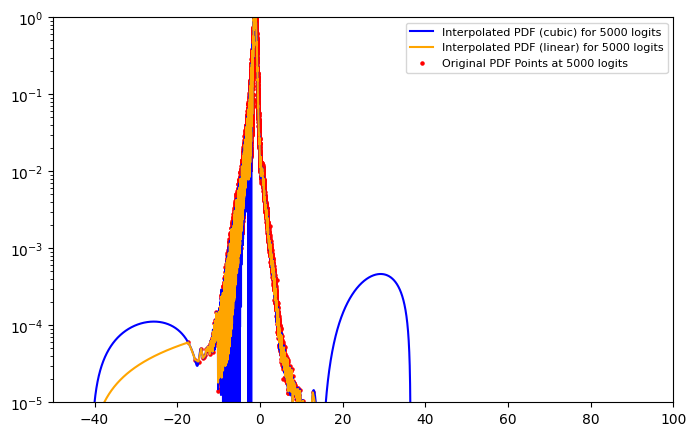

In [60]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Define plot limits
x_lim = (-50, 100)  # Adjust as needed
y_lim = (1e-5, 1)   # Adjust as needed
log_scale = "log"   # or "linear"

# Call the function
plot_pdf_from_logits(ax, logits_t_tensor, borders_np, x_lim, y_lim, log_scale, id=0)

# Show the plot
plt.show()